## Load package, data and functions

### Packages

In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import tkinter
import matplotlib
import matplotlib.pyplot as plt

import time
import Categorical_similarity_measures as sim
import kmedoids

from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard

from sklearn import preprocessing

import sklearn

from sklearn.metrics import silhouette_samples, silhouette_score
import itertools

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

matplotlib.use('TkAgg')

### Functions

Silhuette plot function...

In [247]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [194]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
def sil_plot(distance_matrix,range_n_clusters):
    

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1) = plt.subplots(1)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.5, 1]
        ax1.set_xlim([-0.5, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(distance_matrix) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 47 for reproducibility.
        kmed = kmedoids.fasterpam(distance_matrix,n_clusters, random_state= 47)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X = distance_matrix, labels = kmed.labels, metric='precomputed')

        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X = distance_matrix,labels = kmed.labels, 
                                                      metric='precomputed')

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[kmed.labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.5,-0.4,-0.3,-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(
            "Silhouette analysis for K-Medoids clustering on sample data with %d clusters"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

Dendrogram plot...

In [3]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Data

Overlap distance matrix and sample data...

In [2]:
path1 = "~/Documents/jupyter-workplace/data-mining-assignment/final_sample3000.csv"
sample = pd.read_csv(path1, index_col=0)

path2 = "~/Documents/jupyter-workplace/data-mining-assignment/overlap-distance-matrix.csv"
distmat_overlap = pd.read_csv(path2, index_col=0)

path3 = "~/Documents/jupyter-workplace/data-mining-assignment/jaccard-distance-matrix.csv"
distmat_jaccard = pd.read_csv(path3, index_col=0)

## Check sample

In [5]:
# removendo colunas inutilizadas
sample = sample.drop(["GESTACAO","PESO"], axis=1)

In [7]:
sample

,index,IDADEMAE,ESTCIVMAE,ESCMAE,RACACOR,CODOCUPMAE,CONSULTAS,MESPRENAT,IDANOMAL,parto_prematuro,APGAR
0,176744,21,Uniao consesual,8 a 11 anos,Branca,Vendedor de comércio varejista,Ideal,Segundo mes,Nao,Normal,Normal
1,323299,35,Casada,8 a 11 anos,Branca,Vendedor de comércio varejista,Ideal,Segundo mes,Nao,Normal,Normal
2,8477,35,Solteira,8 a 11 anos,Preta/Parda,Vendedor de comércio varejista,Ideal,Primeiro mes,Nao,Normal,Normal
3,63424,29,Solteira,8 a 11 anos,Preta/Parda,Vendedor de comércio varejista,Ok,Atraso,Nao,Indicio,Normal
4,57551,27,Casada,12 e mais,Branca,Vendedor de comércio varejista,Ok,Atraso,Nao,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...
2995,258787,28,Casada,12 e mais,Branca,Psicólogo clínico,Ideal,Segundo mes,Nao,Normal,Normal
2996,100905,31,Uniao consesual,12 e mais,Branca,Psicólogo clínico,Ideal,Segundo mes,Nao,Normal,Normal
2997,57603,37,Casada,12 e mais,Branca,Psicólogo clínico,Ideal,Segundo mes,Nao,Normal,Normal
2998,118719,32,Casada,12 e mais,Branca,Psicólogo clínico,Ideal,Primeiro mes,Nao,Normal,Normal


## Clustering

### Overlap distance matrix

In [122]:
# random 1000 initialization for kmedoid (higher random state)
temp_score = [0,0,0,0] # k = 2,3,4,5
score = [[] for x in range(100)] # each item will have the variable temp_score
n_clusters = [2,3,4,5]

for i in range(len(score)):
    for n_c in n_clusters:
        kmed = kmedoids.fasterpam(distmat_overlap,n_c, random_state= i) 
        temp_score[n_c-2] = silhouette_score(X = distmat_overlap,
                                             labels = kmed.labels,
                                             metric='precomputed')
    score[i] = max(temp_score)

<Figure size 360x360 with 0 Axes>

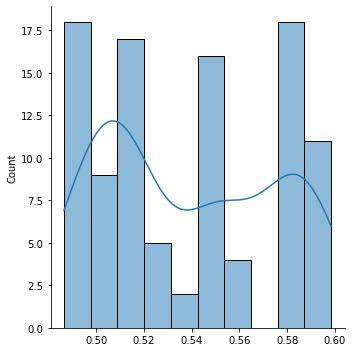

In [138]:
%matplotlib inline
#plot of max sillhuettes from 100 differents random states (seeds)
plt.figure(figsize = (5,5))
sns.displot(score, bins=10, kde=True)
plt.show()

In [165]:
ind_max = np.where(score == max(score))[0][0]
print("Random state: ",ind_max,"\nMax Silhuoette: ",score[ind_max])

Random state:  47 
Max Silhuoette:  0.6420960754683042


In [179]:
# for overlap distance matrix
n_clusters = [2,3,4,5,6]
kmedoids_sil_results = [0,0,0,0,0]
hier_comp_sil_results = [0,0,0,0,0]
hier_avg_sil_results = [0,0,0,0,0]

for i in n_clusters:
    # kmedoid clustering / rs = [4,]
    kmed = kmedoids.fasterpam(distmat_overlap,i, random_state= 47)
    kmedoids_sil_results[i-2] = silhouette_score(X = distmat_overlap, labels = kmed.labels,
                                                 metric='precomputed')
    
    # hierarquical clustering - complete linkage
    model_comp = AgglomerativeClustering(affinity='precomputed', n_clusters = i, linkage='complete')
    hier_comp = model_comp.fit(distmat_overlap)
    hier_comp_sil_results[i-2] = silhouette_score(X = distmat_overlap, labels = hier_comp.labels_,
                                                 metric='precomputed')
    
    # hierarquical clustering - average linkage
    model_avg = AgglomerativeClustering(affinity='precomputed', n_clusters = i, linkage='average')
    hier_avg = model_avg.fit(distmat_overlap)
    hier_avg_sil_results[i-2] = silhouette_score(X = distmat_overlap, labels = hier_avg.labels_,
                                                 metric='precomputed')

In [180]:
Silhouette_Mean = kmedoids_sil_results+hier_comp_sil_results+hier_avg_sil_results
Clustering_Method = (["K-Medoids"]*5)+(["Complete Linkage"]*5)+(["Average Linkage"]*5)
Number_clusters = n_clusters*3

matrix = np.transpose(np.array([Clustering_Method,Number_clusters,Silhouette_Mean]))

sill_evaluation_df = pd.DataFrame(matrix, columns=["Clustering Method","Number of Clusters",
                                                   "Silhouette Mean"])

sill_evaluation_df['Silhouette Mean'] = sill_evaluation_df['Silhouette Mean'].astype("float")
sill_evaluation_df['Number of Clusters'] = sill_evaluation_df['Number of Clusters'].astype("int")
#sill_evaluation_df

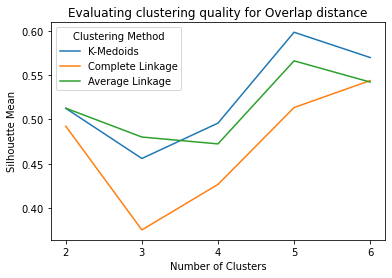

In [181]:
%matplotlib inline

title = "Evaluating clustering quality for Overlap distance"

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

sns.lineplot(data=sill_evaluation_df, 
             x="Number of Clusters", y="Silhouette Mean", hue="Clustering Method").set(title=title)

plt.xticks(ticks=n_clusters, labels=n_clusters)

plt.show()

### Jaccard distance matrix

In [140]:
# random 100 initialization for kmedoid (higher random state)
temp_score = [0,0,0,0] # k = 2,3,4,5
score = [[] for x in range(100)] # each item will have the variable temp_score
n_clusters = [2,3,4,5]

for i in range(len(score)):
    for n_c in n_clusters:
        kmed = kmedoids.fasterpam(distmat_jaccard,n_c, random_state= i) 
        temp_score[n_c-2] = silhouette_score(X = distmat_jaccard,
                                             labels = kmed.labels,
                                             metric='precomputed')
    score[i] = max(temp_score)

<Figure size 360x360 with 0 Axes>

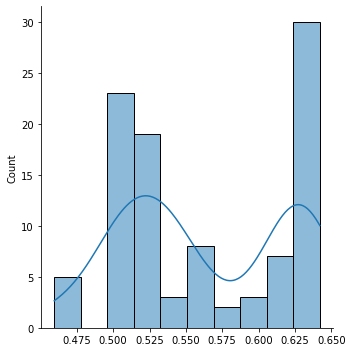

In [144]:
%matplotlib inline
#plot of max sillhuettes from 100 differents random states (seeds)
plt.figure(figsize = (5,5))
sns.displot(score, bins=10, kde=True)
plt.show()

In [145]:
ind_max = np.where(score == max(score))[0][0]
print("Random state: ",ind_max,"\nMax Silhuoette: ",score[ind_max])

Random state:  47 
Max Silhuoette:  0.6420960754683042


In [191]:
# for jaccard distance matrix
n_clusters = [2,3,4,5,6]
kmedoids_sil_results = [0,0,0,0,0]
hier_comp_sil_results = [0,0,0,0,0]
hier_avg_sil_results = [0,0,0,0,0]

for i in n_clusters:
    # kmedoid clustering / rs = [5,1,4,9,10]
    kmed = kmedoids.fasterpam(distmat_jaccard,i, random_state= 47) 
    kmedoids_sil_results[i-2] = silhouette_score(X = distmat_jaccard, labels = kmed.labels,
                                                 metric='precomputed')
    
    # hierarquical clustering - complete linkage
    model_comp = AgglomerativeClustering(affinity='precomputed', n_clusters = i, linkage='complete')
    hier_comp = model_comp.fit(distmat_jaccard)
    hier_comp_sil_results[i-2] = silhouette_score(X = distmat_jaccard, labels = hier_comp.labels_,
                                                 metric='precomputed')
    
    # hierarquical clustering - average linkage
    model_avg = AgglomerativeClustering(affinity='precomputed', n_clusters = i, linkage='average')
    hier_avg = model_avg.fit(distmat_jaccard)
    hier_avg_sil_results[i-2] = silhouette_score(X = distmat_jaccard, labels = hier_avg.labels_,
                                                 metric='precomputed')

In [192]:
Silhouette_Mean = kmedoids_sil_results+hier_comp_sil_results+hier_avg_sil_results
Clustering_Method = (["K-Medoids"]*5)+(["Complete Linkage"]*5)+(["Average Linkage"]*5)
Number_clusters = n_clusters*3

matrix = np.transpose(np.array([Clustering_Method,Number_clusters,Silhouette_Mean]))

sill_evaluation_df = pd.DataFrame(matrix, columns=["Clustering Method","Number of Clusters",
                                                   "Silhouette Mean"])

sill_evaluation_df['Silhouette Mean'] = sill_evaluation_df['Silhouette Mean'].astype("float")
sill_evaluation_df['Number of Clusters'] = sill_evaluation_df['Number of Clusters'].astype("int")
#sill_evaluation_df

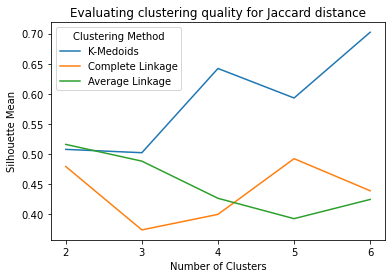

In [193]:
%matplotlib inline

title = "Evaluating clustering quality for Jaccard distance"

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

sns.lineplot(data=sill_evaluation_df, 
             x="Number of Clusters", y="Silhouette Mean", hue="Clustering Method").set(title=title)

plt.xticks(ticks=n_clusters, labels=n_clusters)

plt.show()

### Silhouette Plot

For n_clusters = 4 The average silhouette_score is : 0.6420960754683042


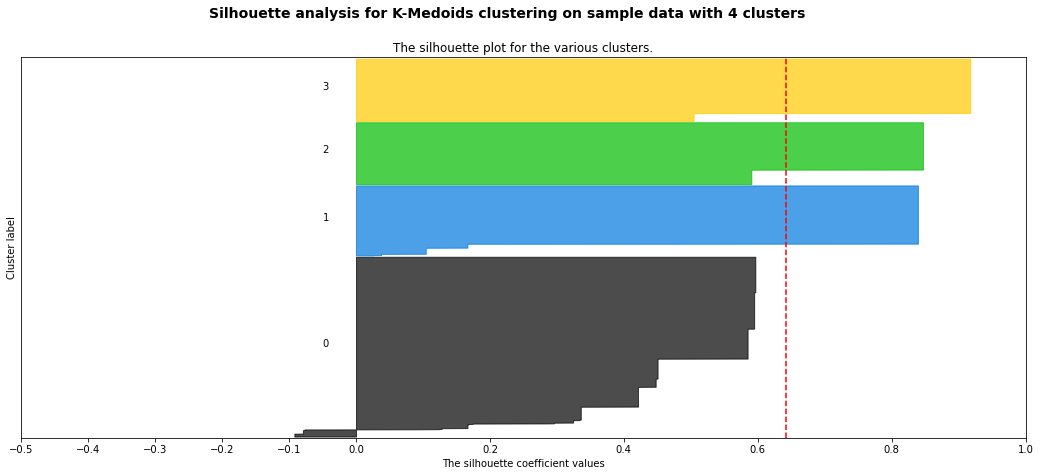

In [196]:
# Silhouette Plot
# Average Linkage k = 5 (Overlap distance)

sil_plot(distmat_jaccard, [4])

In [197]:
# Dendogram
#cluster = AgglomerativeClustering(affinity='precomputed',distance_threshold=0,
#                                  n_clusters = None, linkage='complete')
#model = cluster.fit(distmat_overlap)
#plt.title("Hierarchical Clustering (Average Linkage) Dendrogram (k = 5)")
# plot the top three levels of the dendrogram
#plot_dendrogram(model, truncate_mode="level", p=5)
#plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#plt.show()

### Distance Matrix Visualization

In [3]:
path3 = "~/Documents/jupyter-workplace/data-mining-assignment/jaccard-distance-matrix.csv"
distmat_jaccard = pd.read_csv(path3, index_col=0)

In [4]:
kmed = kmedoids.fasterpam(distmat_jaccard,4, random_state= 47)

perfil_materno = ['ESCMAE','RACACOR','CODOCUPMAE']
cluster_data = sample[perfil_materno].assign(cluster = kmed.labels)
cluster_samp = sample.assign(cluster = kmed.labels)

In [5]:
cluster_samp.to_csv("sample3000_clustered.csv")

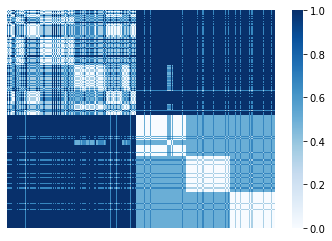

In [295]:
%matplotlib inline

#matriz de distancia separada por cluster
reorder = cluster_data.sort_values(by=['cluster']).index

distmat_jaccard = distmat_jaccard.reindex(columns = reorder.astype('str'))
distmat_jaccard = distmat_jaccard.reindex(reorder)

sns.heatmap(data = distmat_jaccard, xticklabels=False, yticklabels=False, cmap="Blues")

plt.show()

### Silhuoette Validation

In [ ]:

# criar 1000 dummy datasets com reordenamento aleatorio das variaveis, 
# calcular distancia, clusterização com os mesmos settings e criar um histograma de media de silhueta 

In [268]:
#dummy random datasets (with replacement)
shuffled_df = sample[perfil_materno]

#encoding
ocupationenc = preprocessing.LabelEncoder()
ocupationenc.fit(shuffled_df['CODOCUPMAE'])
enc_ocupation_mapping = dict(zip(ocupationenc.classes_, ocupationenc.transform(ocupationenc.classes_)))
shuffled_df['CODOCUPMAE'] = ocupationenc.transform(shuffled_df['CODOCUPMAE'])

racialenc = preprocessing.LabelEncoder()
racialenc.fit(shuffled_df['RACACOR'])
enc_racial_mapping = dict(zip(racialenc.classes_, racialenc.transform(racialenc.classes_)))
shuffled_df['RACACOR'] = racialenc.transform(shuffled_df['RACACOR'])

escolenc = preprocessing.LabelEncoder()
escolenc.fit(shuffled_df['ESCMAE'])
enc_escolaridade_mapping = dict(zip(escolenc.classes_, escolenc.transform(escolenc.classes_)))
shuffled_df['ESCMAE'] = escolenc.transform(shuffled_df['ESCMAE'])

In [269]:
temp = shuffled_df

In [284]:
import random
random.seed(1)
warnings.filterwarnings("ignore")

sill_score = [[] for x in range(100)]

for i in range(len(sill_score)):
    #random dataset
    temp['ESCMAE'] = random.choices(shuffled_df['ESCMAE'], k=len(temp))
    temp['RACACOR'] = random.choices(shuffled_df['RACACOR'], k=len(temp))
    temp['CODOCUPMAE'] = random.choices(shuffled_df['CODOCUPMAE'], k=len(temp))
    # distance matrix
    distmat_temp = pdist(temp, 'jaccard')
    distmat_temp = pd.DataFrame(squareform(distmat_temp), index=temp.index,
                                columns= temp.index)
    # clustering
    kmed_temp = kmedoids.fasterpam(distmat_temp,4, random_state= 47)
    # sill average
    sill_score[i] = silhouette_score(X = distmat_temp,
                                     labels = kmed_temp.labels,
                                     metric='precomputed')

<Figure size 360x360 with 0 Axes>

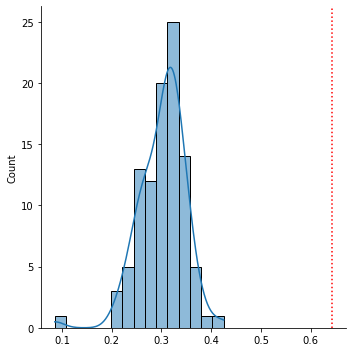

In [299]:
%matplotlib inline
#plot of max sillhuettes from 100 differents random states (seeds)
plt.figure(figsize = (5,5))
sns.displot(sill_score, bins=15, kde=True)
plt.axvline(0.64209, 0,25, c= 'red',ls =':')
plt.show()

In [282]:
?plt.axvline